# the Chennai Water Supply Manager 
 (v4.2: The all-reservoir LSTM model)

# STEP 0: Prepare
1. Import libraries
2. Download data
3. Drop null values

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt



ch=pd.read_csv('D:\Semester 4\Soft Computing\Chennai Water Supply Manager\\CHdianna.csv',parse_dates={'date' : ['Date']},na_values=-1)
pn=pd.read_csv('D:\Semester 4\Soft Computing\Chennai Water Supply Manager\\PNdianna.csv',parse_dates={'date' : ['Date']},na_values=-1)
cz=pd.read_csv('D:\Semester 4\Soft Computing\Chennai Water Supply Manager\\CZdianna.csv',parse_dates={'date' : ['Date']},na_values=-1)
rh=pd.read_csv('D:\Semester 4\Soft Computing\Chennai Water Supply Manager\\RHdianna.csv',parse_dates={'date' : ['Date']},na_values=-1)

def cleaner(pristine):
    pristine=pristine.dropna()


    pristine.reset_index(drop=True, inplace=True)
    pristine['date']=pd.to_datetime(pristine['date'], format='%d/%m/%y').dt.strftime('%d/%m/%y')
    
    print(pristine.isnull().sum())
    return pristine

ch=cleaner(ch)
pn=cleaner(pn)
cz=cleaner(cz)
rh=cleaner(rh)

dianna=[ch,cz,pn,rh]

C:\Users\R. Senthil Kumar\anaconda3\lib\site-packages\ipykernel_launcher.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


date                0
nth day in year     0
Storage (mcft)      0
Inflow (cusecs)     0
Rainfall (mm)       0
Outflow (cusecs)    0
dtype: int64
date                0
nth day in year     0
Storage (mcft)      0
Inflow (cusecs)     0
Rainfall (mm)       0
Outflow (cusecs)    0
dtype: int64
date                0
nth day in year     0
Storage (mcft)      0
Inflow (cusecs)     0
Rainfall (mm)       0
Outflow (cusecs)    0
dtype: int64
date                0
nth day in year     0
Storage (mcft)      0
Inflow (cusecs)     0
Rainfall (mm)       0
Outflow (cusecs)    0
dtype: int64




# STEP 1: PREPROCESSING

1. remove duplicates
2. drop unnecessary columns
3. normalise data(v0: MinMax)
4. prepare sequence dataset
5. train-test split


In [2]:
def sequence_preparer(pristine):
    raw=pristine
    raw=raw.drop(columns=['date','nth day in year'])
    
    cols=['Storage (mcft)', 'Inflow (cusecs)', 'Rainfall (mm)']
    for i in cols:
        maxx=max(raw[i])
        minn=min(raw[i])
        raw[i]-=minn
        raw[i]/=(maxx-minn)
    print(raw.describe())

    #FEATURE EXTRACTION: Prepare sequence



    lookback=5
    sequence=np.zeros(((len(raw)-lookback),lookback,raw.shape[-1]))
    target=np.zeros(len(raw)-lookback)

    for i in range(lookback, len(raw)):
        for j in range(0,lookback):
            sequence[i-lookback][j]=raw.loc[i+j-lookback,:]
        target[i-lookback]=raw['Outflow (cusecs)'][i]
    return raw,sequence,target

ch_raw,ch_sequence,ch_target=sequence_preparer(ch)
cz_raw,cz_sequence,cz_target=sequence_preparer(cz)
pn_raw,pn_sequence,pn_target=sequence_preparer(pn)
rh_raw,rh_sequence,rh_target=sequence_preparer(rh)
sequence=[ch_sequence,cz_sequence,pn_sequence,rh_sequence]
raw=[ch_raw,cz_raw,pn_raw,rh_raw]
target=[ch_target,cz_target,pn_target,rh_target]

       Storage (mcft)  Inflow (cusecs)  Rainfall (mm)  Outflow (cusecs)
count     5088.000000      5088.000000    5088.000000       5088.000000
mean         0.411380         0.005213       0.008791        124.462264
std          0.281939         0.025290       0.035713        639.720457
min          0.000000         0.000000       0.000000          0.000000
25%          0.171231         0.000000       0.000000         48.000000
50%          0.386190         0.000000       0.000000         80.000000
75%          0.648999         0.003933       0.000000        124.000000
max          1.000000         1.000000       1.000000      29000.000000
       Storage (mcft)  Inflow (cusecs)  Rainfall (mm)  Outflow (cusecs)
count     5098.000000      5098.000000    5098.000000       5098.000000
mean         0.284813         0.009561       0.012943         19.778737
std          0.313626         0.044082       0.049306         72.559270
min          0.000000         0.000000       0.000000          0

# STEP 2: Model preparation
* Split data into train and test
* The classic LSTM model with one hidden LSTM layer and output layer with 1 densely connected node


C:\Users\R. Senthil Kumar\anaconda3\lib\site-packages\tensorflow\python\framework\dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
C:\Users\R. Senthil Kumar\anaconda3\lib\site-packages\tensorflow\python\framework\dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
C:\Users\R. Senthil Kumar\anaconda3\lib\site-packages\tensorflow\python\framework\dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
C:\Users\R. Senthil Kumar\anaconda3\lib\site-packages\tensorflow\python\f

(4473, 5, 4) (610, 5, 4) (4473,) (610,)
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 5, 4)]            0         
_________________________________________________________________
lstm (LSTM)                  (None, 32)                4736      
_________________________________________________________________
dense (Dense)                (None, 1)                 33        
Total params: 4,769
Trainable params: 4,769
Non-trainable params: 0
_________________________________________________________________
None
Train on 4473 samples, validate on 610 samples
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
Epoch 1/200
4473/4473 [==============================] - 2s 544us/sample - loss: 126.

4473/4473 [==============================] - 2s 375us/sample - loss: 57.1420 - val_loss: 23.7864
Epoch 62/200
4473/4473 [==============================] - 2s 370us/sample - loss: 57.0440 - val_loss: 23.9332
Epoch 63/200
4473/4473 [==============================] - 2s 339us/sample - loss: 57.2216 - val_loss: 22.8369
Epoch 64/200
4473/4473 [==============================] - 2s 350us/sample - loss: 56.9819 - val_loss: 21.4125
Epoch 65/200
4473/4473 [==============================] - 2s 352us/sample - loss: 56.6857 - val_loss: 22.8462
Epoch 66/200
4473/4473 [==============================] - 2s 379us/sample - loss: 56.7645 - val_loss: 20.6774
Epoch 67/200
4473/4473 [==============================] - 2s 392us/sample - loss: 56.8004 - val_loss: 22.6384
Epoch 68/200
4473/4473 [==============================] - 2s 423us/sample - loss: 56.6558 - val_loss: 20.2689
Epoch 69/200
4473/4473 [==============================] - 2s 375us/sample - loss: 56.6548 - val_loss: 23.7650
Epoch 70/200
4473/4473 

4473/4473 [==============================] - 2s 364us/sample - loss: 54.8406 - val_loss: 24.2064
Epoch 136/200
4473/4473 [==============================] - 3s 605us/sample - loss: 54.9019 - val_loss: 19.8223
Epoch 137/200
4473/4473 [==============================] - 2s 473us/sample - loss: 54.8091 - val_loss: 20.8937
Epoch 138/200
4473/4473 [==============================] - 2s 478us/sample - loss: 54.7559 - val_loss: 22.8286
Epoch 139/200
4473/4473 [==============================] - 2s 500us/sample - loss: 54.7762 - val_loss: 22.5016
Epoch 140/200
4473/4473 [==============================] - 1s 330us/sample - loss: 54.8711 - val_loss: 25.5976
Epoch 141/200
4473/4473 [==============================] - 1s 267us/sample - loss: 54.6946 - val_loss: 22.0570
Epoch 142/200
4473/4473 [==============================] - 2s 438us/sample - loss: 54.7285 - val_loss: 22.1050
Epoch 143/200
4473/4473 [==============================] - 2s 517us/sample - loss: 54.7138 - val_loss: 23.5386
Epoch 144/200
4

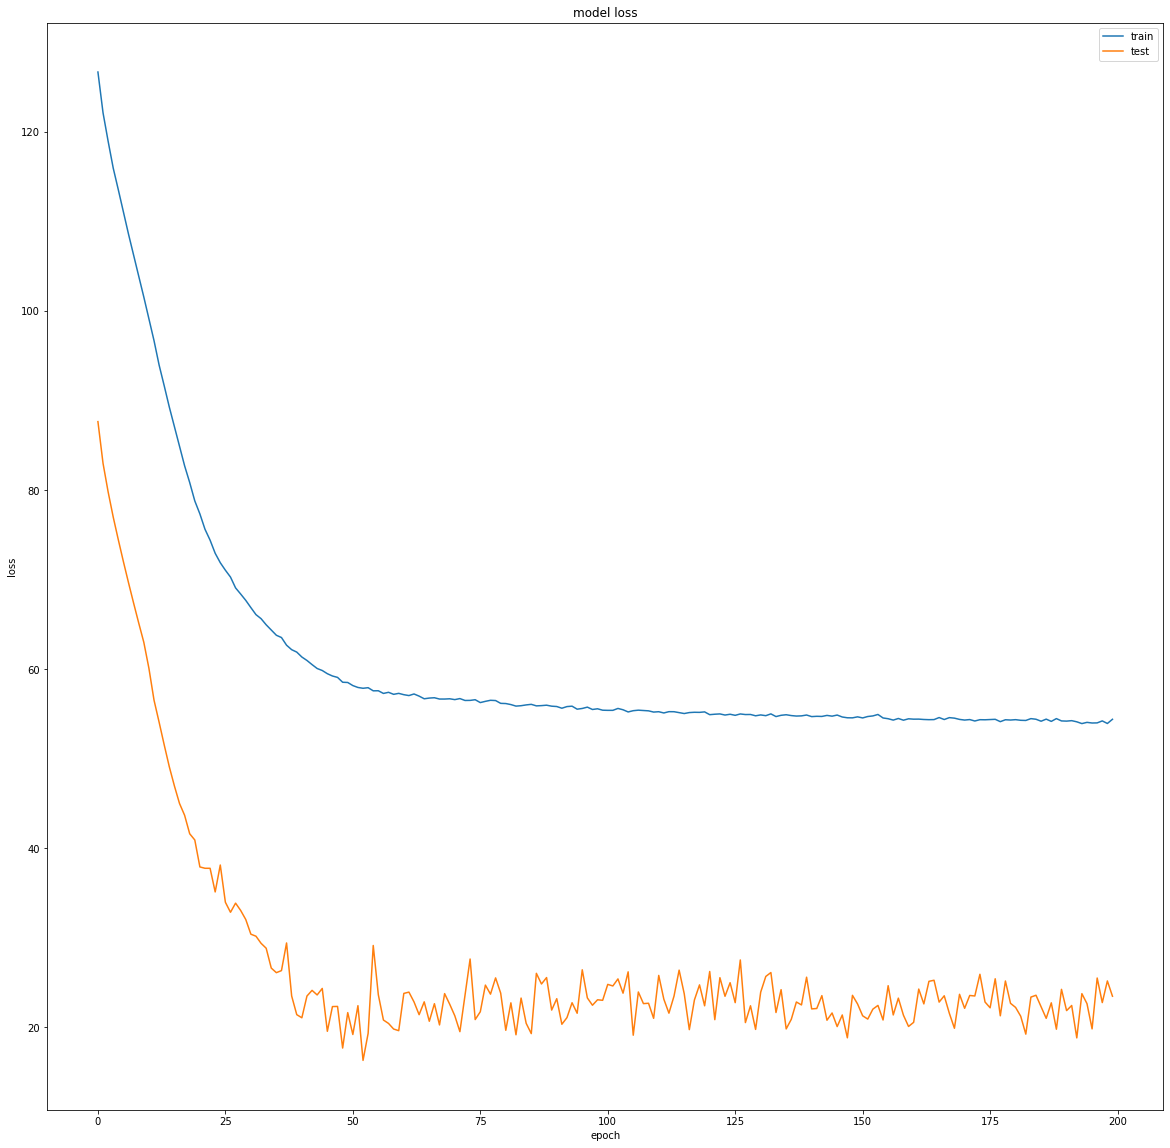

(4481, 5, 4) (612, 5, 4) (4481,) (612,)
Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 5, 4)]            0         
_________________________________________________________________
lstm (LSTM)                  (None, 32)                4736      
_________________________________________________________________
dense (Dense)                (None, 1)                 33        
Total params: 4,769
Trainable params: 4,769
Non-trainable params: 0
_________________________________________________________________
None
Train on 4481 samples, validate on 612 samples
Epoch 1/200
4481/4481 [==============================] - 5s 1ms/sample - loss: 10.1264 - val_loss: 1.4300
Epoch 2/200
4481/4481 [==============================] - 1s 306us/sample - loss: 9.8820 - val_loss: 1.3973
Epoch 3/200
4481/4481 [==============================] - 2s 390us/sample - loss: 9.7

4481/4481 [==============================] - 1s 329us/sample - loss: 8.4320 - val_loss: 1.2659
Epoch 69/200
4481/4481 [==============================] - 2s 371us/sample - loss: 8.4823 - val_loss: 1.4314
Epoch 70/200
4481/4481 [==============================] - 1s 324us/sample - loss: 8.3265 - val_loss: 1.2635
Epoch 71/200
4481/4481 [==============================] - 1s 291us/sample - loss: 8.4351 - val_loss: 1.4676
Epoch 72/200
4481/4481 [==============================] - 1s 296us/sample - loss: 8.4240 - val_loss: 1.3886
Epoch 73/200
4481/4481 [==============================] - 1s 323us/sample - loss: 8.4619 - val_loss: 1.2773
Epoch 74/200
4481/4481 [==============================] - 2s 361us/sample - loss: 8.4908 - val_loss: 1.4178
Epoch 75/200
4481/4481 [==============================] - 2s 386us/sample - loss: 8.3575 - val_loss: 1.3639
Epoch 76/200
4481/4481 [==============================] - 2s 475us/sample - loss: 8.4166 - val_loss: 1.2883
Epoch 77/200
4481/4481 [=================

4481/4481 [==============================] - 2s 449us/sample - loss: 7.6968 - val_loss: 1.2500
Epoch 144/200
4481/4481 [==============================] - 2s 501us/sample - loss: 8.0392 - val_loss: 1.3680
Epoch 145/200
4481/4481 [==============================] - 1s 264us/sample - loss: 7.9581 - val_loss: 1.3369
Epoch 146/200
4481/4481 [==============================] - 1s 289us/sample - loss: 8.0003 - val_loss: 1.7655
Epoch 147/200
4481/4481 [==============================] - 1s 254us/sample - loss: 7.9700 - val_loss: 1.5439
Epoch 148/200
4481/4481 [==============================] - 1s 238us/sample - loss: 7.9506 - val_loss: 1.3792
Epoch 149/200
4481/4481 [==============================] - 1s 243us/sample - loss: 7.8823 - val_loss: 1.4861
Epoch 150/200
4481/4481 [==============================] - 1s 264us/sample - loss: 8.0179 - val_loss: 1.6378
Epoch 151/200
4481/4481 [==============================] - 1s 290us/sample - loss: 8.0685 - val_loss: 1.5555
Epoch 152/200
4481/4481 [========

<Figure size 432x288 with 0 Axes>

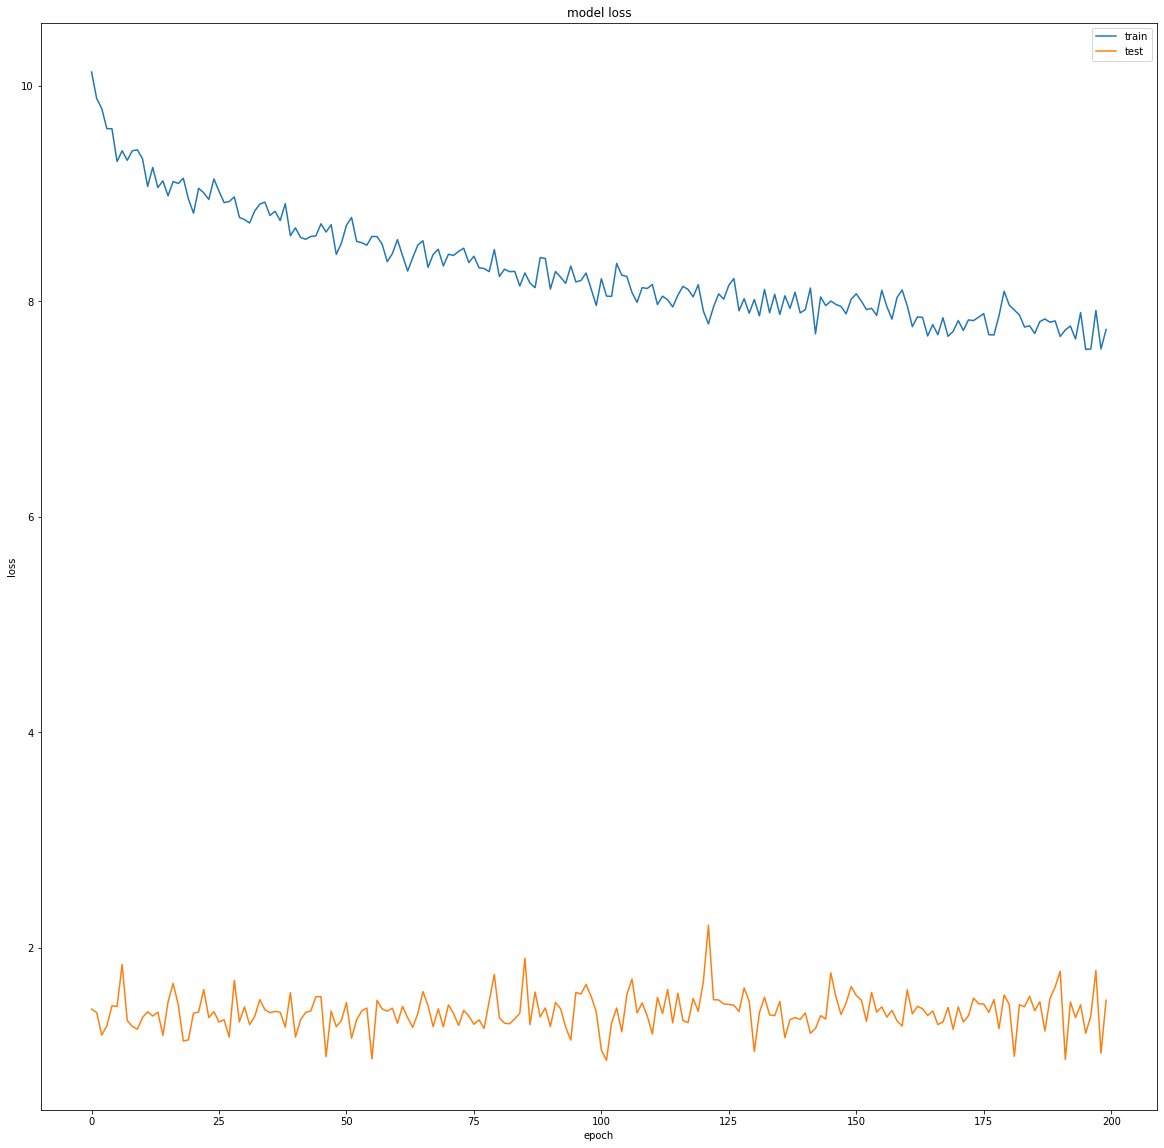

(4473, 5, 4) (610, 5, 4) (4473,) (610,)
Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 5, 4)]            0         
_________________________________________________________________
lstm (LSTM)                  (None, 32)                4736      
_________________________________________________________________
dense (Dense)                (None, 1)                 33        
Total params: 4,769
Trainable params: 4,769
Non-trainable params: 0
_________________________________________________________________
None
Train on 4473 samples, validate on 610 samples
Epoch 1/200
4473/4473 [==============================] - 4s 800us/sample - loss: 138.8881 - val_loss: 29.6743
Epoch 2/200
4473/4473 [==============================] - 1s 234us/sample - loss: 137.0347 - val_loss: 29.1720
Epoch 3/200
4473/4473 [==============================] - 1s 233us/sample - lo

4473/4473 [==============================] - 1s 240us/sample - loss: 117.6567 - val_loss: 25.2011
Epoch 68/200
4473/4473 [==============================] - 1s 242us/sample - loss: 117.4606 - val_loss: 26.3331
Epoch 69/200
4473/4473 [==============================] - 1s 237us/sample - loss: 117.2321 - val_loss: 22.9435
Epoch 70/200
4473/4473 [==============================] - 1s 239us/sample - loss: 117.0288 - val_loss: 27.2713
Epoch 71/200
4473/4473 [==============================] - 1s 227us/sample - loss: 117.1063 - val_loss: 27.3915
Epoch 72/200
4473/4473 [==============================] - 1s 249us/sample - loss: 116.6643 - val_loss: 27.5995
Epoch 73/200
4473/4473 [==============================] - 1s 243us/sample - loss: 116.7478 - val_loss: 31.3423
Epoch 74/200
4473/4473 [==============================] - 1s 242us/sample - loss: 116.4310 - val_loss: 28.7870
Epoch 75/200
4473/4473 [==============================] - 1s 238us/sample - loss: 116.0143 - val_loss: 24.7146
Epoch 76/200
4

4473/4473 [==============================] - 1s 240us/sample - loss: 110.6876 - val_loss: 27.6107
Epoch 141/200
4473/4473 [==============================] - 1s 230us/sample - loss: 110.4593 - val_loss: 29.6509
Epoch 142/200
4473/4473 [==============================] - 1s 234us/sample - loss: 111.2731 - val_loss: 29.9780
Epoch 143/200
4473/4473 [==============================] - 1s 237us/sample - loss: 110.9036 - val_loss: 28.0140
Epoch 144/200
4473/4473 [==============================] - 1s 241us/sample - loss: 110.5995 - val_loss: 25.6903
Epoch 145/200
4473/4473 [==============================] - 1s 240us/sample - loss: 111.7409 - val_loss: 31.2819
Epoch 146/200
4473/4473 [==============================] - 1s 236us/sample - loss: 111.2122 - val_loss: 27.8389
Epoch 147/200
4473/4473 [==============================] - 1s 234us/sample - loss: 110.0957 - val_loss: 26.0638
Epoch 148/200
4473/4473 [==============================] - 1s 232us/sample - loss: 110.0985 - val_loss: 27.8143
Epoch 

<Figure size 432x288 with 0 Axes>

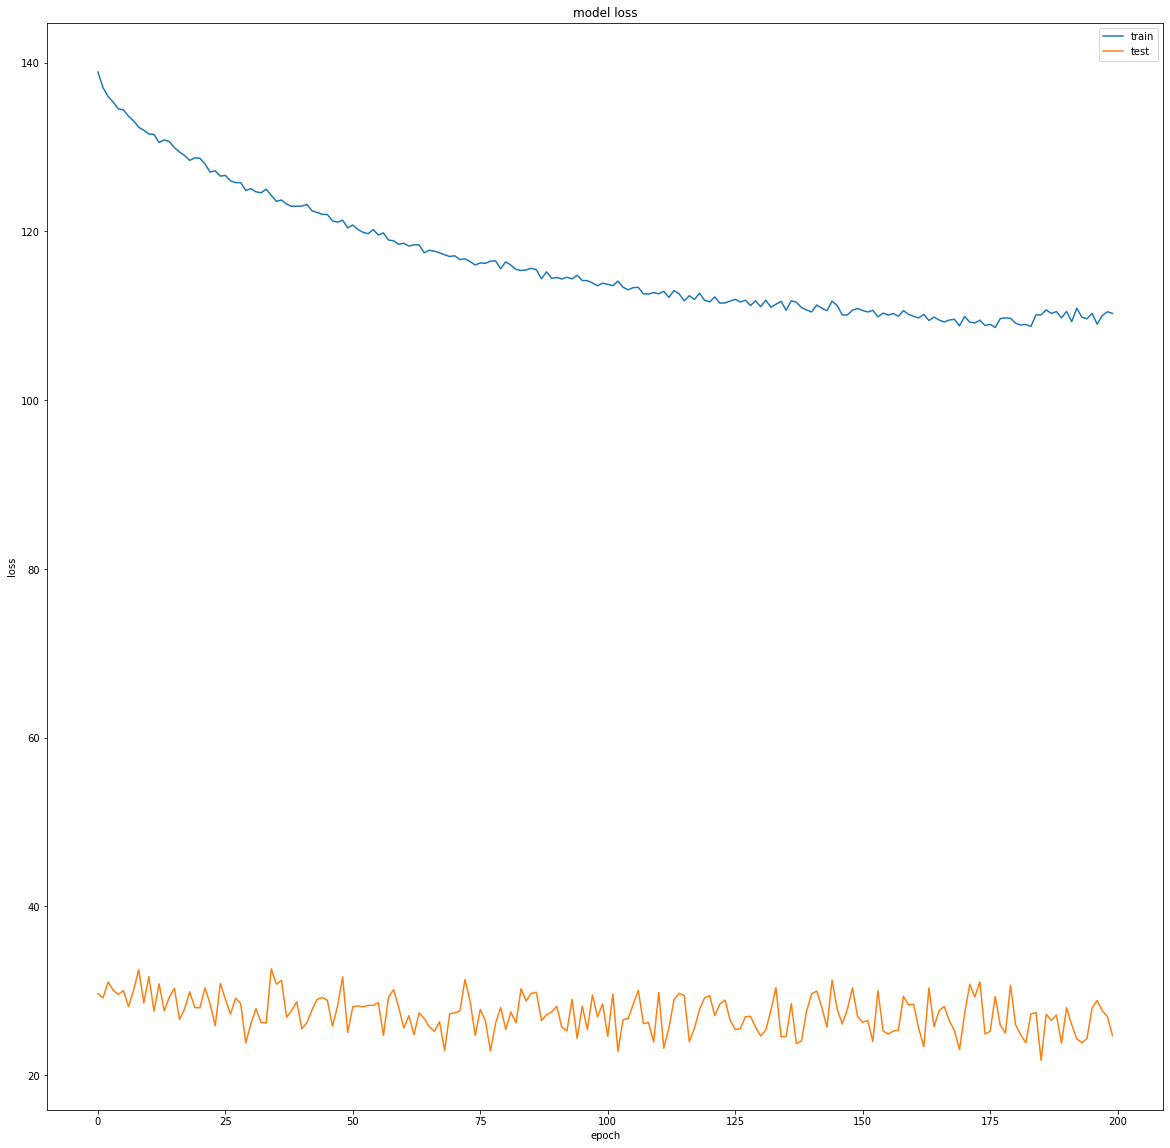

(4472, 5, 4) (610, 5, 4) (4472,) (610,)
Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 5, 4)]            0         
_________________________________________________________________
lstm (LSTM)                  (None, 32)                4736      
_________________________________________________________________
dense (Dense)                (None, 1)                 33        
Total params: 4,769
Trainable params: 4,769
Non-trainable params: 0
_________________________________________________________________
None
Train on 4472 samples, validate on 610 samples
Epoch 1/200
4472/4472 [==============================] - 3s 781us/sample - loss: 28.5100 - val_loss: 16.4184
Epoch 2/200
4472/4472 [==============================] - 1s 237us/sample - loss: 27.3743 - val_loss: 19.9448
Epoch 3/200
4472/4472 [==============================] - 1s 236us/sample - loss

Epoch 68/200
4472/4472 [==============================] - 1s 231us/sample - loss: 23.3695 - val_loss: 20.4239
Epoch 69/200
4472/4472 [==============================] - 1s 243us/sample - loss: 23.6028 - val_loss: 20.6009
Epoch 70/200
4472/4472 [==============================] - 1s 241us/sample - loss: 23.5768 - val_loss: 26.7022
Epoch 71/200
4472/4472 [==============================] - 1s 236us/sample - loss: 23.4793 - val_loss: 20.7240
Epoch 72/200
4472/4472 [==============================] - 1s 241us/sample - loss: 23.4982 - val_loss: 24.8504
Epoch 73/200
4472/4472 [==============================] - 1s 234us/sample - loss: 23.1079 - val_loss: 22.4826
Epoch 74/200
4472/4472 [==============================] - 1s 228us/sample - loss: 23.2486 - val_loss: 19.5619
Epoch 75/200
4472/4472 [==============================] - 1s 247us/sample - loss: 23.3879 - val_loss: 23.7277
Epoch 76/200
4472/4472 [==============================] - 1s 235us/sample - loss: 23.7481 - val_loss: 23.7298
Epoch 77/2

Epoch 142/200
4472/4472 [==============================] - 2s 377us/sample - loss: 22.2924 - val_loss: 26.6781
Epoch 143/200
4472/4472 [==============================] - 2s 385us/sample - loss: 22.9262 - val_loss: 24.1591
Epoch 144/200
4472/4472 [==============================] - 2s 396us/sample - loss: 22.5210 - val_loss: 25.3040
Epoch 145/200
4472/4472 [==============================] - 1s 299us/sample - loss: 22.3408 - val_loss: 28.7352
Epoch 146/200
4472/4472 [==============================] - 1s 297us/sample - loss: 22.3140 - val_loss: 19.5634
Epoch 147/200
4472/4472 [==============================] - 1s 285us/sample - loss: 22.3615 - val_loss: 26.8419
Epoch 148/200
4472/4472 [==============================] - 1s 282us/sample - loss: 22.3579 - val_loss: 23.7006
Epoch 149/200
4472/4472 [==============================] - 1s 286us/sample - loss: 22.5189 - val_loss: 24.4269
Epoch 150/200
4472/4472 [==============================] - 1s 281us/sample - loss: 22.4984 - val_loss: 26.4697
E

<Figure size 432x288 with 0 Axes>

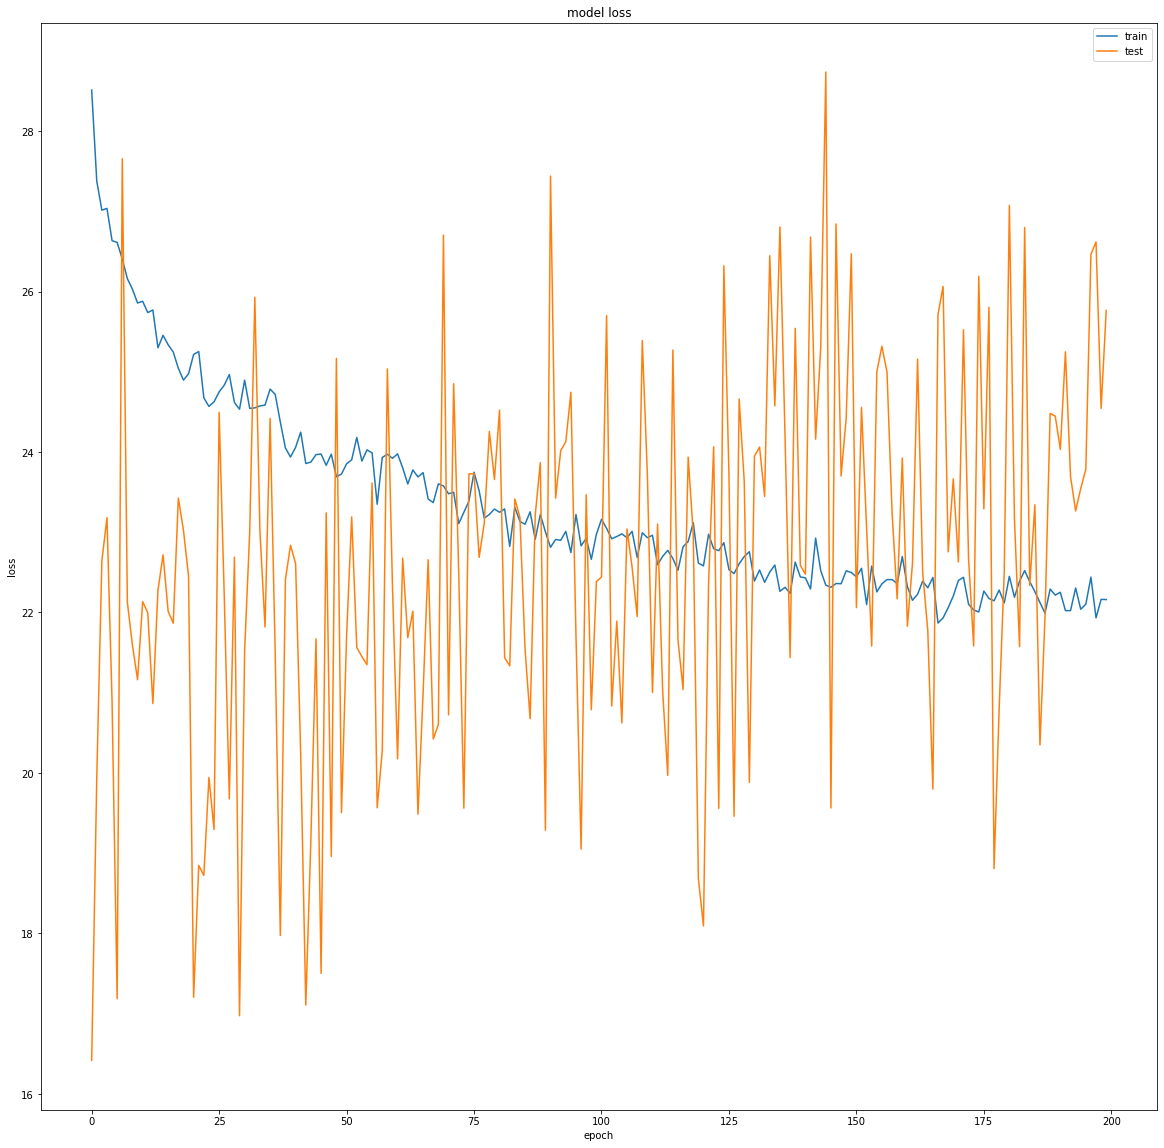

<Figure size 432x288 with 0 Axes>

In [3]:
from tensorflow.keras import models
from tensorflow.keras import optimizers
from tensorflow.keras import layers
first=[]
hidden=[]
output=[]
DhanVan4=[]
def train_test_split(sequence,target,boundary=0.88):
    if(boundary<1):
        x_train=sequence[:int(len(sequence)*boundary)]
        x_test=sequence[int(len(sequence)*boundary):]
        y_train=target[:int(len(target)*boundary)]
        y_test=target[int(len(target)*boundary):]
    else:
        x_train=sequence[:boundary]
        x_test=sequence[boundary:]
        y_train=target[:boundary]
        y_test=target[boundary:]
    
    return x_train, x_test, y_train, y_test
index=-1
def brain(sequence,target,index=index+1):
    x_train, x_test, y_train, y_test=train_test_split(sequence,target)
    print(x_train.shape,
        x_test.shape,
        y_train.shape,
        y_test.shape)
    first.append(layers.Input(shape=(x_train.shape[1], x_train.shape[2])))
    hidden.append(layers.LSTM(32,
                            dropout=0.25,
                            recurrent_dropout=0.25,
                            #return_sequences=True,
                             )(first[index]))


    output.append(layers.Dense(1,activation='relu')(hidden[index]))
    DhanVan4.append(models.Model(first[index],output[index]))
    DhanVan4[index].compile(loss='mae', optimizer=optimizers.RMSprop())
    #DhanVan4[index].name='DhanVan4:-'+str(index)+'.'
    print(DhanVan4[index].summary())

    history = DhanVan4[index].fit(x_train, y_train, 
                        epochs=200,  
                        validation_data=(x_test, y_test))
    sa='model'+str(index)+'.h5'
    st='model'+str(index)+'.jpeg'
    
    DhanVan4[index].save(sa)
    plt.figure(figsize=(20,20))
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('model loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train', 'test'], loc='upper right')
    plt.show()
    plt.savefig(st)
    return DhanVan4[index-1]


DhanvanA=brain(ch_sequence,ch_target)

DhanvanB=brain(cz_sequence,cz_target)

DhanvanC=brain(pn_sequence,pn_target)

DhanvanD=brain(rh_sequence,rh_target)

DhanVan4=[DhanvanA,DhanvanB,DhanvanC,DhanvanD]

In [4]:
for i in range(4):
    print(DhanVan4[i].layers)

[<tensorflow.python.keras.engine.input_layer.InputLayer object at 0x0000012F69343D08>, <tensorflow.python.keras.layers.recurrent.LSTM object at 0x0000012F693485C8>, <tensorflow.python.keras.layers.core.Dense object at 0x0000012F69348CC8>]
[<tensorflow.python.keras.engine.input_layer.InputLayer object at 0x0000012F69343D08>, <tensorflow.python.keras.layers.recurrent.LSTM object at 0x0000012F693485C8>, <tensorflow.python.keras.layers.core.Dense object at 0x0000012F69348CC8>]
[<tensorflow.python.keras.engine.input_layer.InputLayer object at 0x0000012F69343D08>, <tensorflow.python.keras.layers.recurrent.LSTM object at 0x0000012F693485C8>, <tensorflow.python.keras.layers.core.Dense object at 0x0000012F69348CC8>]
[<tensorflow.python.keras.engine.input_layer.InputLayer object at 0x0000012F69343D08>, <tensorflow.python.keras.layers.recurrent.LSTM object at 0x0000012F693485C8>, <tensorflow.python.keras.layers.core.Dense object at 0x0000012F69348CC8>]


In [5]:
model[1].layers

NameError: name 'model' is not defined

In [ ]:
pn.tail()

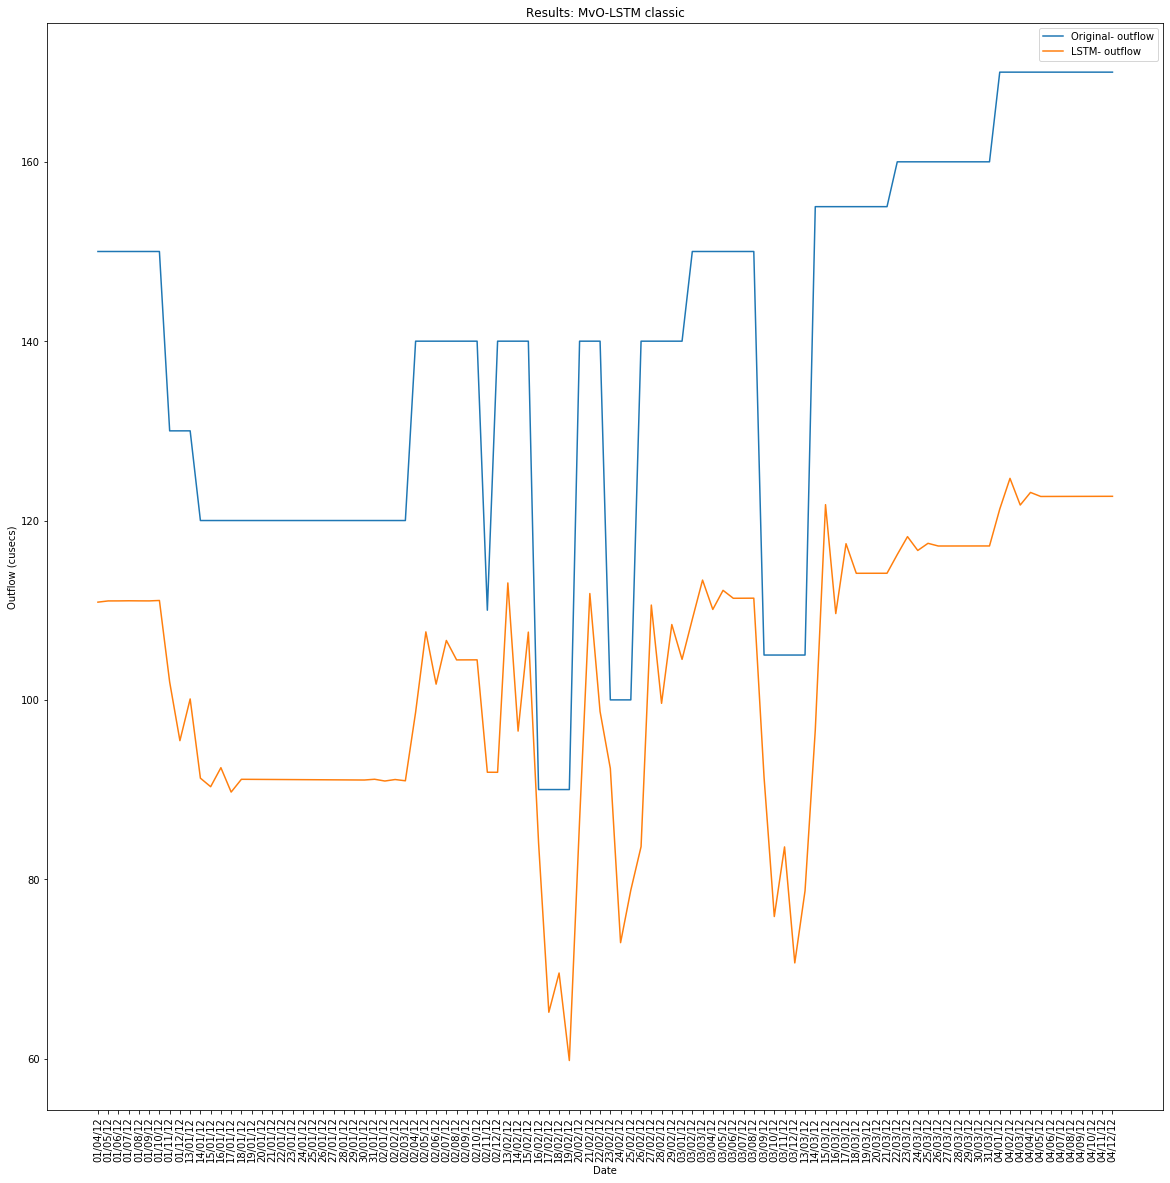

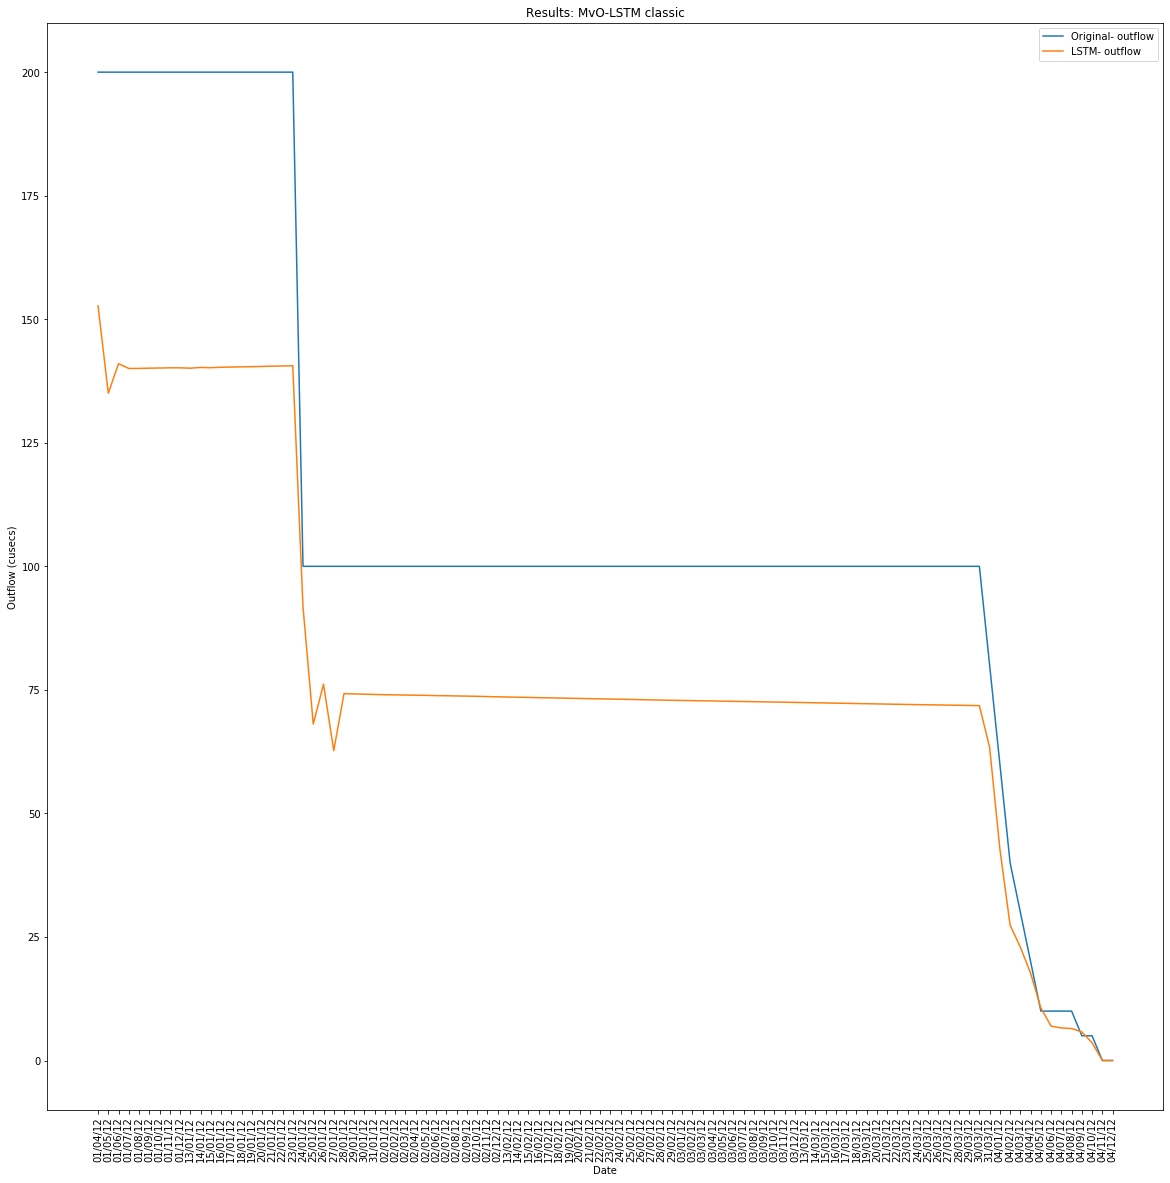

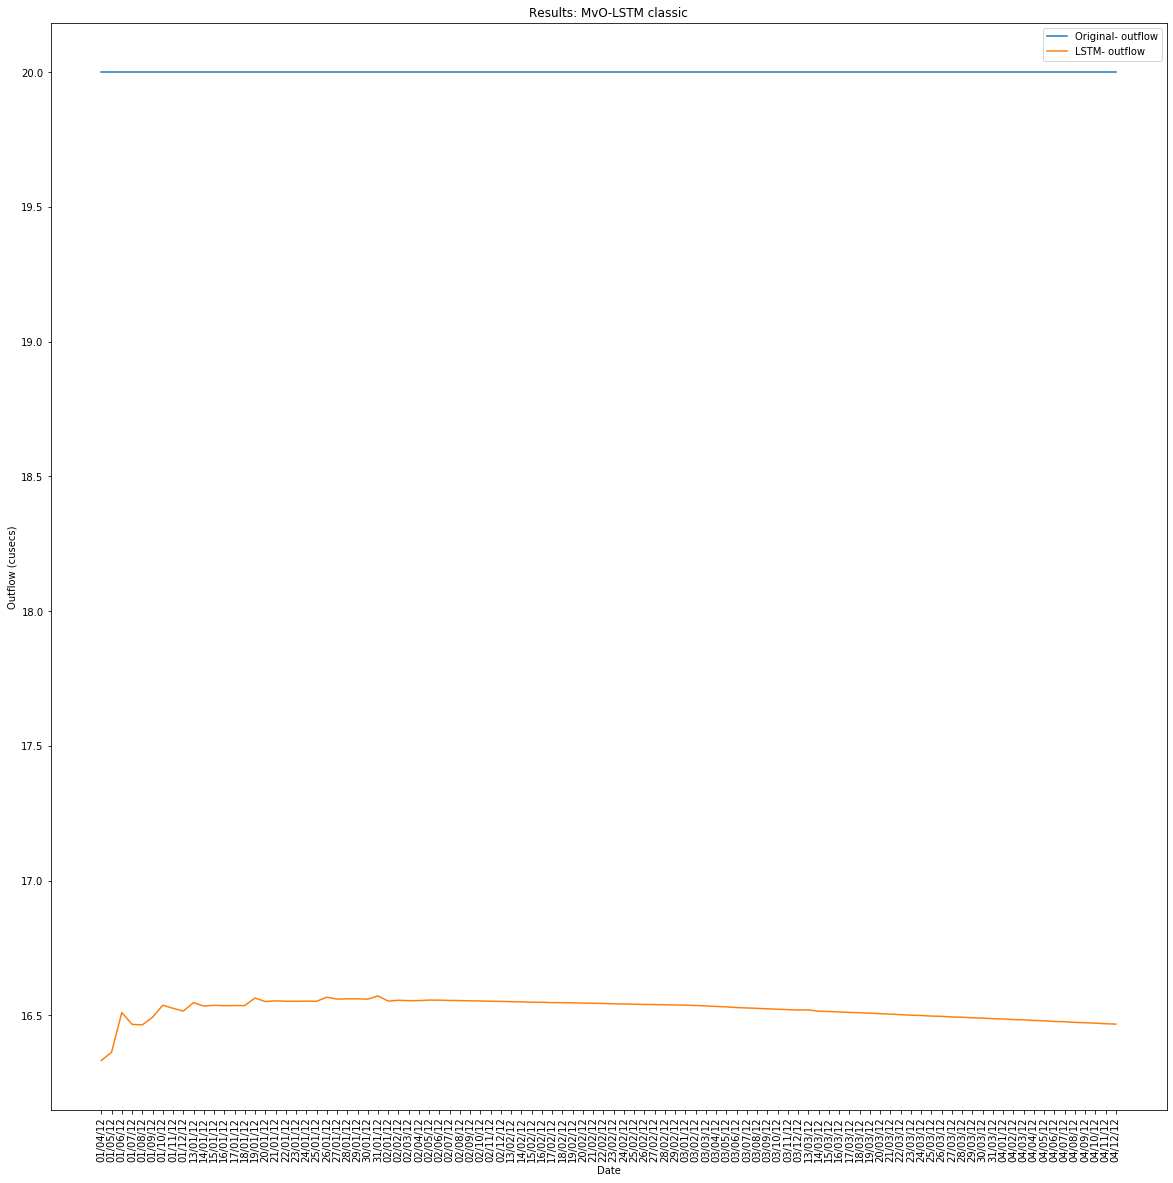

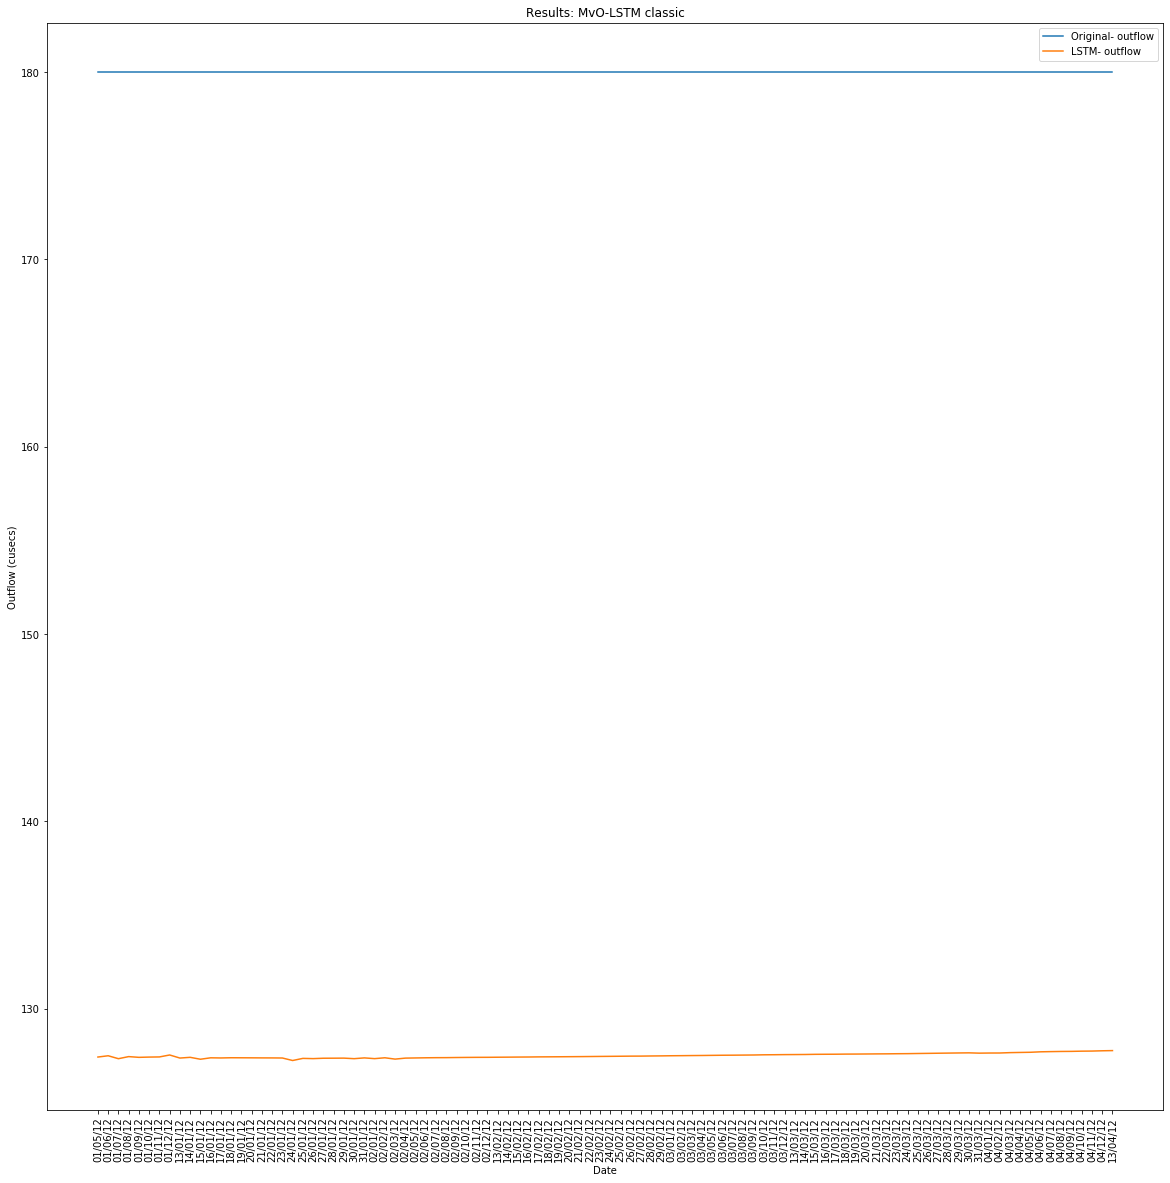

In [6]:
lookback=5
def plotter(model,pristine,sequence):
        
        raw=pristine.drop(columns=['date','nth day in year'])
    
        cols=['Storage (mcft)', 'Inflow (cusecs)', 'Rainfall (mm)']
        for i in cols:
            maxx=max(raw[i])
            minn=min(raw[i])
            raw[i]-=minn
            raw[i]/=(maxx-minn)
        start=5
        end=4300
        
        s1=start+1
        e1=end+1


        start=365*8+0
        end=start+100

        s1=start+1
        e1=end+1
        output=model.predict(sequence[s1:e1])
        plt.figure(figsize=(20,20))
        plt.plot(pristine.loc[start+lookback:end+lookback-1,'date'].values,pristine.loc[start+lookback:end+lookback-1,['Outflow (cusecs)']].values,label='Original- outflow')
        plt.plot(pristine.loc[start+lookback:end+lookback-1,'date'].values,output,label='LSTM- outflow')
        plt.xticks(rotation=90)
        plt.legend()
        plt.title('Results: MvO-LSTM classic')
        plt.ylabel('Outflow (cusecs)')
        plt.xlabel('Date')
        #plt.legend('Original-Chembarambaakam outflow','LSTM-Chembarambaakam outflow')
        #plt.savefig('D:\\Semester 4\\Soft Computing\\Chennai Water Supply Manager\\v0.jpeg')
        plt.show()
dianna=[ch,cz,pn,rh]
for i in range(4):
    plotter(DhanVan4[i],dianna[i],sequence[i])

In [7]:
DhanVanStar=models.Model([first[0],first[1],first[2],first[3]],[output[0],output[1],output[2],output[3]])

In [20]:
hidden[0]

<tf.Tensor 'lstm/strided_slice_7:0' shape=(?, 32) dtype=float32>

In [21]:

from keras.utils.vis_utils import plot_model
plot_model(DhanVanStar, to_file='model_plot.png', show_shapes=True, show_layer_names=True)

"dot" with args ['-Tps', 'C:\\Users\\RE726~1.SEN\\AppData\\Local\\Temp\\tmp5a_1ska6'] returned code: 1

stdout, stderr:
 b''
b"'C:\\Users\\R.' is not recognized as an internal or external command,\r\noperable program or batch file.\r\n"



AssertionError: 1

In [ ]:
DhanVanStar.predict([sequence[0][0:1],sequence[1][0:1],sequence[2][0:1],sequence[3][0:1]])

In [ ]:
!pip install pydot

In [ ]:
import numpy as np
import gym

from keras.models import Sequential, Model
from keras.layers import Dense, Activation, Flatten, Input, Concatenate
from keras.optimizers import Adam

from rl.agents import DDPGAgent
from rl.memory import SequentialMemory
from rl.random import OrnsteinUhlenbeckProcess


ENV_NAME = 'Pendulum-v0'


# Get the environment and extract the number of actions.
env = gym.make(ENV_NAME)
np.random.seed(123)
env.seed(123)
assert len(env.action_space.shape) == 1
nb_actions = env.action_space.shape[0]

# Next, we build a very simple model.
actor = Sequential()
actor.add(Flatten(input_shape=(1,) + env.observation_space.shape))
actor.add(Dense(16))
actor.add(Activation('relu'))
actor.add(Dense(16))
actor.add(Activation('relu'))
actor.add(Dense(16))
actor.add(Activation('relu'))
actor.add(Dense(nb_actions))
#actor.add(Activation('linear'))
print(actor.summary())

action_input = Input(shape=(nb_actions,), name='action_input')
observation_input = Input(shape=(1,) + env.observation_space.shape, name='observation_input')
flattened_observation = Flatten()(observation_input)
x = Concatenate()([action_input, flattened_observation])
x = Dense(32)(x)
x = Activation('relu')(x)
x = Dense(32)(x)
x = Activation('relu')(x)
x = Dense(32)(x)
x = Activation('relu')(x)
x = Dense(1)(x)
#x = Activation('linear')(x)
critic = Model(inputs=[action_input, observation_input], outputs=x)
print(critic.summary())

# Finally, we configure and compile our agent. You can use every built-in Keras optimizer and
# even the metrics!
memory = SequentialMemory(limit=100000, window_length=1)
random_process = OrnsteinUhlenbeckProcess(size=nb_actions, theta=.15, mu=0., sigma=.3)
agent = DDPGAgent(nb_actions=nb_actions, actor=actor, critic=critic, critic_action_input=action_input,
                  memory=memory,
                  nb_steps_warmup_critic=100, nb_steps_warmup_actor=100,gamma=.99, target_model_update=1e-3
                  )
agent.compile(Adam(lr=.001, clipnorm=1.), metrics=['mae'])

# Okay, now it's time to learn something! We visualize the training here for show, but this
# slows down training quite a lot. You can always safely abort the training prematurely using
# Ctrl + C.
agent.fit(env, nb_steps=50000, visualize=True, verbose=1, nb_max_episode_steps=200)

# After training is done, we save the final weights.
agent.save_weights('ddpg_{}_weights.h5f'.format(ENV_NAME), overwrite=True)

# Finally, evaluate our algorithm for 5 episodes.
agent.test(env, nb_episodes=5, visualize=True, nb_max_episode_steps=200)